# To Begin

This is a practical part of your ASR-TTS course. In total you will have 5 labs. Three of which will be focused on Automatic Speech Recognition and two on Text-to-Speech models. Each lab will last two hours and consist of two parts:
* Reading Part
* Coding Part 

In each part you might find question or tasks/activities to complete. 

LAB 4/5

# What will you learn in LAB 4?
* Understand TTS pipeline, from raw text to generated speech
* Explain the difference between text processing, acoustic modeling, and vocoder stages
* Convert text into linguistic representations (characters, phonemes, tokens)
* Run a basic neural TTS model to synthesize speech from text
* Evaluate TTS quality using subjective listening and basic objective criteria


# Text-to-Speech (TTS)

## <span style="color:blue"> Introduction </span>


In this lab, first, we will study how to build and evaluate a neural-based TTS system using a pretrained Tacotron 2 in torchaudio and different vocoders. Then, we will use a multi-speaker TTS model for experiments with different voices using SpeechBrain pretrained models.


The TTS pipeline comprises 3 steps:

<img src="tts.png">


#### <span style="color:blue"> Step 1. Text processing </span>

The input text is encoded into a list of symbols. We will use English characters and phonemes as the symbols. A phonemizer transforms text into phoneme sequences. Phonemes are textual representations of the pronunciation of words. 

#### <span style="color:blue"> Step 2. Spectrogram generation </span>

From the encoded text, a spectrogram is generated. We use the ``Tacotron 2``
model for this. 

#### <span style="color:blue"> Step 3. Conversion of the spectrogram into a waveform (speech generation) </span>

The spectrogram is converted into a speech waveform using a Vocoder.
In this lab, three different vocoders are used,
   * `~torchaudio.models.WaveRNN`,
   * `~torchaudio.transforms.GriffinLim`, and
   * [Nvidia's WaveGlow](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/).


The related components are bundled in :py:class:`torchaudio.pipelines.Tacotron2TTSBundle`.



# Block diagram of the Tacotron 2 system architecture

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" width="500">

The Tacotron 2 and WaveGlow model form a TTS system that enables user to synthesise a natural sounding speech from raw transcripts without any additional prosody information. 
The Tacotron 2 model produces mel spectrograms from input text using encoder-decoder architecture. 
WaveGlow is a flow-based model that consumes the mel spectrograms to generate speech.

*Note: 
    This lab is partly based on the [torchaudio tutorial](https://pytorch.org/audio/stable/tutorials/tacotron2_pipeline_tutorial.html) and [SpeechBrain](https://github.com/speechbrain/speechbrain) examples.*

In [ ]:
import os
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
from torchmetrics.audio import NonIntrusiveSpeechQualityAssessment
from speechbrain.inference.TTS import MSTacotron2
from speechbrain.inference.vocoders import HIFIGAN

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Speech and transcripts sub-directories paths
data_dir = "../dataset"
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## <span style="color:blue"> Step 1. Text processing </span>

### Character-based encoding

In this section, we will learn how character-based encoding works.

Since the pre-trained Tacotron 2 model expects specific set of symbol
tables, the same functionalities is available in ``torchaudio``. However,
we will first manually implement the encoding for better understanding.

First, we define a set of symbols
``'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'``. Then, we map  each character of the input text into the index of the corresponding symbol in the table. Symbols that are not in the table are ignored.



In [ ]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
print(text_to_sequence(text))

As mentioned above, the symbol table and indices must match
what the pretrained Tacotron 2 model expects. ``torchaudio`` provides the same
transform along with the pretrained model. You can
instantiate and use such transform as follows.

In [ ]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
processed, lengths = processor(text)

print(processed)
print(lengths)

Note: The output of our manual encoding and the ``torchaudio`` ``text_processor`` output matches (meaning we correctly re-implemented what the library does internally). It takes either a text or list of texts as inputs.
When a list of texts are provided, the returned ``lengths`` variable
represents the valid length of each processed tokens in the output
batch.

The intermediate representation can be retrieved as follows:




In [ ]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it
uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme)
model.

The detail of the G2P model is out of the scope of this tutorial, we will
just look at what the conversion looks like.

Similar to the case of character-based encoding, the encoding process is
expected to match what a pretrained Tacotron 2 model is trained on.
``torchaudio`` has an interface to create the process.

The following code illustrates how to make and use the process. Behind
the scene, a G2P model is created using ``DeepPhonemizer`` package, and
the pretrained weights published by the author of ``DeepPhonemizer`` is
fetched.




In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

Notice that the encoded values are different from the example of
character-based encoding.

The intermediate representation looks as follows.


In [ ]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

## <span style="color:blue"> Step 2. Spectrogram generation </span>


``Tacotron 2`` is the model we use to generate spectrogram from the
encoded text. For more details, please refer to [the
paper](https://arxiv.org/abs/1712.05884).

It is easy to instantiate a Tacotron 2 model with pretrained weights,
however, note that the input to Tacotron 2 models need to be processed
by the matching text processor.

`torchaudio.pipelines.Tacotron2TTSBundle` bundles the matching
models and processors together so that it is easy to create the pipeline.

For the available bundles, and its usage, please refer to
`~torchaudio.pipelines.Tacotron2TTSBundle`.

Documentation: https://docs.pytorch.org/audio/main/generated/torchaudio.pipelines.Tacotron2TTSBundle.html




In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

**Note that ``Tacotron2.infer`` method perfoms multinomial sampling,
therefore, the process of generating the spectrogram incurs randomness.**

**Multinomial sampling** is a probabilistic decoding method where a model randomly selects an output according to a predicted probability distribution rather than always choosing the most likely option. In `Tacotron2.infer`, multinomial sampling is used at each decoding step when generating the mel-spectrogram, which means that even with the same input text, the model can produce slightly different spectrograms across runs. This randomness arises because lower-probability outputs can occasionally be sampled, and these small differences can propagate over time in the autoregressive decoder, leading to natural variations in prosody, timing, and pitch.

**EXAMPLE**

Imagine a model predicts the next output with these probabilities:
* Option A: 70%
* Option B: 20%
* Option C: 10%

With multinomial sampling, the model:
* Draws a random sample according to these probabilities
* A is chosen most of the time, but B or C can occasionally be chosen
* So the result is probabilistic, not deterministic.

Why TTS models use it
* Multinomial sampling:
* Avoids overly flat or robotic speech
* Encourages natural variation
* Better mimics human speech diversity



torch.Size([80, 570])
torch.Size([80, 598])
torch.Size([80, 557])


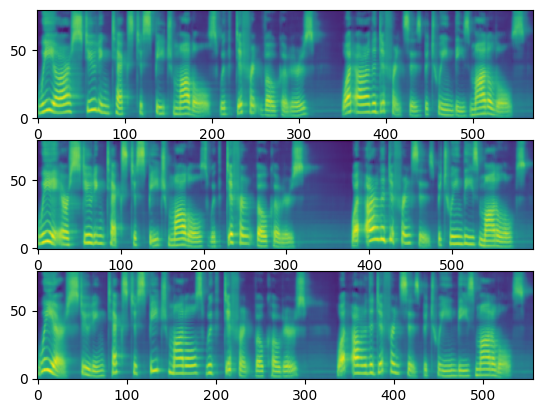

In [9]:
fig, ax = plt.subplots(3, 1)
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

## <span style="color:blue"> Step 3. Waveform generation using different vocoders </span>

The obtained spectrogram is used to generate a waveform using a vocoder.

``torchaudio`` provides vocoders based on ``GriffinLim`` and ``WaveRNN``.

### WaveRNN vocoder

Continuing from the previous section, we can instantiate the matching
WaveRNN model from the same bundle.




In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "We are studing text-to-speech models"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

In [ ]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

plot(waveforms, spec, vocoder.sample_rate)

### Griffin-Lim vocoder

The usage of the Griffin-Lim vocoder is similar to WaveRNN. You can instantiate the vocoder object with
`~torchaudio.pipelines.Tacotron2TTSBundle.get_vocoder`
method and pass the spectrogram.




### Question:

Using the code above as a reference write the code using GRIFFINLIM vocoder and PHONE encoding, create a spectogram.

In [ ]:
#Your model

In [ ]:
#Your spectogram

### Waveglow vocoder

Waveglow is a vocoder published by Nvidia. The pretrained weights are published on Torch Hub. One can instantiate the model using ``torch.hub`` module.

WaveGlow converts mel-spectrograms into time-domain audio waveforms; it is a non-autoregressive model that generates the waveform in parallel, making it much faster at inference than autoregressive vocoders such as WaveRNN, but also more computationally demanding and therefore best suited for GPU use. WaveGlow is based on normalizing flows, learns an invertible mapping from noise to speech conditioned on a spectrogram, does not perform text-to-speech on its own, and is typically used after an acoustic model like Tacotron2. NVIDIA provides pretrained WaveGlow weights via Torch Hub, allowing the model to be easily instantiated with torch.hub without training it from scratch.

In [ ]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

In [ ]:
plot(waveforms, spec, 22050)
# Save and display the waverform
torchaudio.save("synthesized_sample.wav", waveforms.squeeze(1).cpu(), 22050)

### Question:

Now that we went though the coding process of TTS, step-by-step explain how TTS works in **your own words.**

In [ ]:
#Your Answer

### Modifying the voice: Let's have fun

*Let’s have fun:* modifying spectrograms to change a voice is **not** just a toy experiment, similar techniques that has been used for in audio effects, voice conversion, and speech processing. While modern neural TTS systems automate these transformations through learned controls rather than manual edits, the core idea remains the same: **changing the spectral representation changes how a voice is perceived**.

### How can we edit a spectogram?


#### First, let us obtain the spectogram we will edit

Use wavernn to produce a spectogram

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device).eval()

text = "We are studying text to speech models."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed, lengths = processed.to(device), lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)


In [ ]:
plot(waveforms, spec, sample_rate = 22050)


### Possible Modification List

<span style="color:red"> **DO NOT RUN THE CELL BELOW, READ**</span>


In [ ]:
import torch.nn.functional as F

In [ ]:
# Time stretch: makes the spectrogram shorter or longer in time
# Divisor MUST be > 0
# Larger value = faster (shorter), smaller value = slower (longer)
spec_fast = F.interpolate(spec, size=int(spec.shape[-1] / 1.2), mode="linear")
spec_slow = F.interpolate(spec, size=int(spec.shape[-1] / 0.8), mode="linear")


# Pitch shift: moves all energy up or down along the frequency axis
# shifts MUST be integer
# Recommended range: -8 to +8 mel bins
# Too large values will push energy out of range
spec_high = torch.roll(spec, shifts=+4, dims=1)
spec_low  = torch.roll(spec, shifts=-4, dims=1)


# Smoothing: averages nearby time frames and frequency bins
# kernel_size values MUST be positive odd integers
# Minimum: (3, 3)
# Recommended range: (3–15, 5–25)
# Larger kernels = more smoothing (can remove detail)
spec_smooth = F.avg_pool2d(
    spec.unsqueeze(1),
    kernel_size=(7, 11),   # (frequency_bins, time_frames)
    stride=1,
    padding=(3, 5)
).squeeze(1)


# Add noise: adds random energy everywhere in the spectrogram
# Noise scale MUST be >= 0
spec_noise = spec + 0.25 * torch.randn_like(spec)


# High-frequency reduction: lowers energy in the highest frequency bins
# Number of bins MUST be < total mel bins 
# n_mels = spec.size(1); print(f"Number of mel bins: {n_mels}")

spec_m = spec.clone()
spec_m[:, -20:, :] -= 1.5

#Example: spec_m[:, 40:70, :] -= 3.0 -> Mid/high-frequency reduction:
# 40:70 selects mel bins from index 40 to 69 (a mid-to-high frequency band)
# 3.0 is the amount of energy reduction (larger value = stronger removal)


### Now, we will modify a spectogram for the audio to sound faster 

*This function below is necessary because after modifying a spectrogram, the audio must be regenerated by the vocoder so that the waveform and spectrogram correspond to the same signal.*


In [65]:
#Helper function
def wavernn_from_mel(spec, vocoder):
    spec_lengths = torch.tensor([spec.shape[-1]], device=spec.device)

    with torch.inference_mode():
        waveforms, _ = vocoder(spec, spec_lengths)

    return waveforms

In [ ]:
spec_fast = F.interpolate(spec, size=int(spec.shape[-1] / 1.2), mode="linear")

wave_fast = wavernn_from_mel(spec_fast, vocoder)

plot(wave_fast, spec_fast, vocoder.sample_rate)


### Question: Experiment with different modifications and fill out the table

You can apply more than one modification at once

| Target voice effect | Spectrogram modifications used | 
| ------------------- | ------------------------------ | 
| Robot voice         |                                |                                     
| Child voice         |                                |                                     
| Very slow whisper   |                                |                                     


## <span style="color:blue"> Subjective evaluation </span>

Subjective evaluation with MOS (Mean Opinion Score) is the standard way to assess the perceptual quality and naturalness of text-to-speech systems. In a MOS test, human listeners rate speech samples on a fixed scale, typically from 1 to 5, based on how speech sounds. Unlike objective metrics, MOS directly reflects human perception, capturing aspects such as voice quality, prosody, and artifacts that are difficult to measure automatically. Because running real listening tests is time-consuming, modern labs often rely on MOS predictors (e.g., NISQA or wvMOS) that estimate these scores automatically; however, the interpretation remains the same as for human ratings (we will see tham later).


This is the official definition of MOS listening tests and an authoritative standard used in speech research.
https://www.itu.int/rec/T-REC-P.800/
(you can download the PDF), see from the page 26 in the document: "B.4.5 Opinion scales recommended by the ITU-T"


### Question: MOS
read the paper “A critical analysis of MOS test methodology in TTS evaluation” and in your own words explain some pitfalls of using MOS. Why is it risky to compare MOS values across different papers? If you were reviewing a TTS paper, what minimum MOS reporting details would you require before trusting the results?

https://www.isca-archive.org/ssw_2023/kirkland23_ssw.pdf

In [ ]:
# Your answer

### <span style="color:red"> **Question: exercise 1**</span>

<span style="color:orange"> **Speech-to-text generation and subjective evaluation**</span>


1. Use text transcripts from the text files in */asr-dataset/transcription* (directory from the previous ASR labs). Select a subsample of 3-10 files, preferably including different speakers of the original dataset (different speakers have different first numbers in the file names, i.e. file 121-121726-0002.txt corresponds to speaker #121, file 61-70968-0018.txt - to speaker #61). Synthesize speech for these files three times using three different vocoders.
3. Listen to the obtained synthesised audio samples and evaluate them in terms of speech naturalness and intelligibility using the scale 1 to 5. See *Subjective Evaluation* reading for more details on the criteria of evaluation, REMEMBER TO DEFINE YOUR SCALE CLEARLY BEFORE THE RANKING.
4. Based on these scores, perform ranking of the vocoders and describe the problems you observe (mispronunciation, wrong intonation, etc.) for each vocoder regarding speech naturalness and intelligibility and provide audio examples (one for each factor is sufficient).




## <span style="color:blue"> Objective evaluation </span>

### Objective evaluation using ASR

Sometimes, instead of human listeners, the ASR model can be used as an analogue for speech intelligibility assessment.
The WER metric is computed between the reference text and the output of the ASR system applied to the synthesized speech sample.

WER is useful when you want to:
* compare intelligibility across TTS systems
* measure the impact of: noise, vocoder choice, spectrogram modifications, check whether speech remains understandable.





### Question: produce an audio using a chosen TTS algorithm and compute WER

You can use your previous labs for help

In [ ]:
# code

### Objective evaluation using NISQA (Non Intrusive Speech Quality Assessment)

This part is devoted to the objective evaluation of speech quality and naturalness using NISQA models. NISQA (Neural Intrusive Speech Quality Assessment) predicts a Mean Opinion Score (MOS), which is an estimate of how humans would rate the quality of the speech on a scale typically ranging from 1 (very poor) to 5 (excellent). In these examples, for simplicity, we use a general NISQA model trained for overall speech quality assessment; however, for proper evaluation of text-to-speech systems, a specialized NISQA-TTS model should normally be used, as it is better aligned with TTS artifacts and naturalness. The model output contains several values, and the first value corresponds to the overall MOS estimate, which is the main score to use in this lab. Higher MOS values indicate more natural and higher-quality speech, while lower values suggest audible artifacts or unnatural sounding output.

https://github.com/gabrielmittag/NISQA

In [ ]:
nisqa = NonIntrusiveSpeechQualityAssessment(22050)

waveform, sr = torchaudio.load('synthesized_sample.wav', channels_first=True)
nisqa.update(waveform)
fig, ax_ = nisqa.plot()
fig.savefig("nisqa_synthesized_test.png")

# Float tensor with shape (...,5) 
# corresponding to overall MOS, noisiness, discontinuity, coloration and loudness in that order
print(nisqa(waveform))

### Objective evaluation using MOS prediction

This part is devoted to objective MOS score prediction by the fine-tuned wav2vec2.0 model.


We will need to fix some dependency issues to run the following metric and instal a wvmos package, if after the pip install scripts it is still not running, you can skip this section...

In [ ]:
!pip install wvmos

In [ ]:
!pip install "transformers<4.30"


In [ ]:
from wvmos import get_wvmos

# force all torch.load calls to map to CPU (temporary patch) 
_orig_torch_load = torch.load
def _cpu_torch_load(*args, **kwargs):
    kwargs.setdefault("map_location", torch.device("cpu"))
    return _orig_torch_load(*args, **kwargs)

torch.load = _cpu_torch_load

model = get_wvmos(cuda=False)

torch.load = _orig_torch_load



In [ ]:
mos = model.calculate_one("synthesized_sample.wav")
print(mos)


### <span style="color:red"> **Question: exercise 2**</span>

<span style="color:orange"> **Objective evaluation** </span>

1. Use the audios you generated for **subjective evaluation** exercise 1.
2. Compute MOS predictions using neural network wv-MOS and NISQA models.
3. Do you observe similar or different ranking of the TTS systems when using subjective (in Exercise 1) and objective scores?



## <span style="color:blue"> Multi-speaker TTS </span>

This part is devoted to Zero-Shot Multi-Speaker TTS with SpeechBrain toolkit using a variation of Tacotron 2, extended to incorporate speaker identity information when generating speech. It is pretrained on the [LibriTTS](https://openslr.org/60/) corpus (multi-speaker English corpus of approximately 585 hours of read English).

Multi-speaker TTS refers to text-to-speech systems that can synthesize speech in the voices of many different speakers instead of being limited to a single voice. These systems encode voice identity by learning a speaker embedding, which is a compact numerical representation that captures characteristics of a speaker’s voice, such as pitch range, timbre, speaking style, and articulation patterns. During training, the model is exposed to speech from many different speakers and learns to separate linguistic content (what is being said) from speaker characteristics (who is speaking). A dedicated speaker encoder processes a short reference audio signal and converts it into a fixed-length embedding vector that summarizes the speaker’s identity. This embedding is then injected into the TTS model (for example, concatenated with text or acoustic features), conditioning the speech generation process so that the synthesized output follows the same voice characteristics. In zero-shot multi-speaker TTS, the model can generate speech in a new speaker’s voice because the speaker encoder has learned a general representation of voices, allowing it to extract identity information from unseen speakers without retraining.

*Note*:
    The model generates speech at a rate of 22050 Hz, but it's important to note that the input signal, crucial for capturing speaker identities, must be sampled at 16kHz.



In [ ]:
#Intialize TTS (mstacotron2) and Vocoder (HiFIGAN)
ms_tacotron2 = MSTacotron2.from_hparams(source="speechbrain/tts-mstacotron2-libritts", savedir="pretrained_models/tts-mstacotron2-libritts")
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-22050Hz", savedir="pretrained_models/tts-hifigan-libritts-22050Hz")

In [ ]:
# Examples of reference files for different speakers
# audio_file_reference = '121-127105-0006.wav' # female voice
# audio_file_reference = '61-70968-0004.wav' # male voice
audio_file_reference_path = '/home/aine/Teaching/ASR-TTS-Course/asr-dataset/speech/61-70968-0004.wav' 
print(f"Audio file reference path: {audio_file_reference_path}")

waveform, sr = torchaudio.load(audio_file_reference_path, channels_first=True)

In [ ]:
IPython.display.Audio(data=waveform, rate=sr)

In [ ]:
text = "Hello! This is a multi-speaker text-to-speech model. We generate a test sample."

# Running the Zero-Shot Multi-Speaker Tacotron2 model to generate mel-spectrogram
mel_outputs, mel_lengths, alignments = ms_tacotron2.clone_voice(text, audio_file_reference_path)

# Running Vocoder (spectrogram-to-waveform)
waveforms = hifi_gan.decode_batch(mel_outputs)

# Save and display the waverform
torchaudio.save("synthesized_sample.wav", waveforms.squeeze(1).cpu(), 22050)
IPython.display.Audio(data=waveforms.squeeze(1), rate=22050)

### **<span style="color:red"> Question: exercise 3 </span>**

<span style="color:orange"> **Multi-speaker TTS** </span>


1. Use wav files from  */dataset/transcription* (directory from the previous (#1-3) ASR labs). Take a subsample of files, the same as you used in Exercise 1. Synthesize speech for these files several times using the multi-speaker SpeechBrain Tacotron 2 model and HiFi-GAN vocoder by providing different samples of different speakers.
2. Listen to the obtained synthesised audio samples and evaluate them in terms of speech naturalness and intelligibility using the scale 1..5. You do not need to listen to all the synthesis files. For this subjective evaluation (listening test), only 1-2 samples of each speaker is sufficient to listen.
3. Apply an objective metric (i.e. wv-MOS) to the synthesized files.
4. Are there any differences in speech quality depending on the reference speaker voice? If yes, could you specify the most difficult/simple voice(s) for TTS synthesis? What are the characteristics of these voices and main differences?
   



### **<span style="color:red"> Question: exercise 4 </span>**

Record your own voice and run Multispeaker TTS. How close is the generated speech to your own voice?

## What is the “sociology of translation” (in plain words)?

The sociology of translation describes how a real-world problem is turned into a technical system, step by step.

* Problematisation: define the goal, e.g. detecting a neurological disease from speech.
* Interessement: decide how to collect data, e.g. recording speech via smartphone in controlled conditions.
* Enrolment: choose technical methods, e.g. MFCC features and a neural network classifier.
* Mobilisation: evaluate and deploy the system, e.g. using AUC as a metric and applying it as a screening tool.

Problematisation → Interessement → Enrolment → Mobilisation


## Question: produce the sociology of translation diagram for voice biomarkers. 

For each step, specify the name of the step, and give an example of a design choice made during this step.

In [ ]:
# Your answer

## Practice: LTI systems

Here are some resources on LTI systems.
For your exam you MIGHT have to know how to draw LTI systems from equations and how to derive formulas from graphs. Please make sure to study it.

https://www.youtube.com/watch?v=O9VvhRPFsiY

https://www.youtube.com/watch?v=Y-h7qoTVQtw
